In [2]:
import numpy as np

import qiskit
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler, Estimator
# from qiskit.primitives import Estimator
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit import  Aer
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_provider import IBMProvider

from sklearn.model_selection import train_test_split
import time
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import os


import LHC_QML_module as lqm

In [3]:
# settings to tune

seed = 123
# Features to train on
training_feature_keys = [
    "f_mass4l",
    # "f_eta4l",
    "f_Z2mass",
    "f_Z1mass",
]

save_folder = os.path.join("saved", "model1b-qiskit")

batch_size = 2
n_epochs = 1

train_data_size = 80
test_data_size = 80
valid_data_size = 40
total_datasize = train_data_size + test_data_size + valid_data_size
half_datasize = total_datasize // 2 # 80 signal and 80 backgrounds
# opt = NesterovMomentumOptimizer(0.1)
# opt = SPSAOptimizer(maxiter=200)

is_local_simulator = True

spsa_alpha = 0.5
spsa_gamma = 0.101
spsa_c     = 0.2
spsa_A     = 2.
spsa_a1    = 0.2
spsa_a     = spsa_a1 * (spsa_A + 1) ** spsa_alpha

In [4]:
np.random.seed(seed)

if os.path.exists(save_folder):
    print(f"This notebook may overwrite previous results in the {save_folder} directory")
else:
    os.makedirs(save_folder)

In [5]:
n_qubits = 3
num_layers = 2

# weights_init = 0.5 * np.random.randn(num_layers, n_qubits, requires_grad=True)
weights_init = 0.5 * np.random.randn(num_layers , n_qubits, 3)
weights_init = weights_init.flatten()

In [6]:
qc_template = QuantumCircuit(n_qubits)

par_inputs = ParameterVector("input", n_qubits)
par_weights = ParameterVector("weights", len(weights_init))

# input
for i in range(n_qubits):
    qc_template.rx(par_inputs[i], i)


# first layer
offset = 0
for i in range(n_qubits):
    qc_template.rz(par_weights[offset + i*3 + 0], i)
    qc_template.ry(par_weights[offset + i*3 + 1], i)
    qc_template.rz(par_weights[offset + i*3 + 2], i)
qc_template.cx(0, 1)
qc_template.cx(1, 2)
qc_template.cx(2, 0)

# second layer
offset = 3 * n_qubits
for i in range(n_qubits):
    qc_template.rz(par_weights[offset + i*3 + 0], i)
    qc_template.ry(par_weights[offset + i*3 + 1], i)
    qc_template.rz(par_weights[offset + i*3 + 2], i)
qc_template.cx(0, 2)
qc_template.cx(1, 0)
qc_template.cx(2, 1)

# qc_template.measure_all()
obs = SparsePauliOp("IXX")



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:164: UserWarning: Style JSON file 'clifford.json' not found in any of these locations: /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/qiskit/visualization/circuit/styles/clifford.json, clifford.json. Will use default style.
  self._style, def_font_ratio = load_style(style)


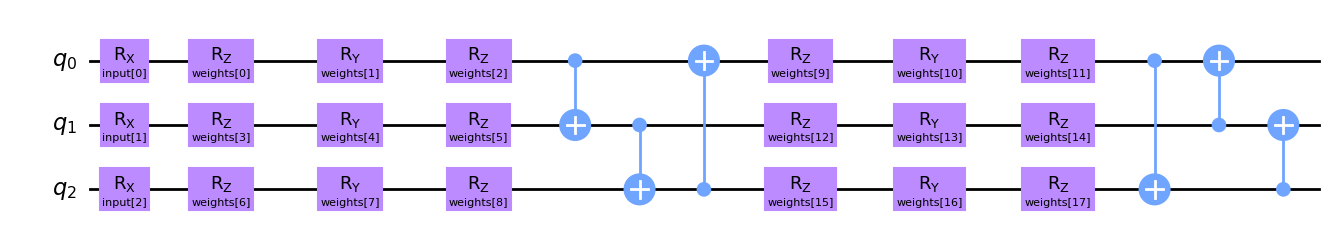

In [7]:
qc_template.draw("mpl", style="clifford")

In [8]:
def loss(prob, label):
    # print(prob)
    return -np.mean(label*np.log(prob+1e-5)+(1-label)*np.log(1-prob+1e-5))

def accuracy(pred, label):
    return np.mean(np.isclose(pred,label))

def cost(weights, features, labels):
    probs = np.array([model(weights, f) for f in features])
    return loss(probs, labels)

In [9]:
signals_folder = "./../qml-lhc/data/signal/higgs"
backgrounds_folder = "./../qml-lhc/data/background/higgs"


use_pca = False



num_features = len(training_feature_keys)


# load data from files
signal_dict, background_dict, files_used = lqm.load_data(
    signals_folder, backgrounds_folder, training_feature_keys
)

# formats data for input into vqc
features, labels = lqm.format_data(signal_dict, background_dict)


n_signal_events = (labels == 1).sum()
n_background_events = (labels == 0).sum()

features_signal = features[(labels==1)]
features_background = features[(labels==0)]

np.random.shuffle(features_signal)
np.random.shuffle(features_background)

features = np.concatenate((features_signal[:half_datasize], features_background[:half_datasize]))
# labels = np.array([1]*half_datasize + [0]*half_datasize, requires_grad=False)
labels = np.array([1]*half_datasize + [0]*half_datasize)

# splits data into testing and training sets
train_features, rest_features, train_labels, rest_labels = train_test_split(
    features,
    labels,
    train_size=train_data_size,
    test_size=test_data_size + valid_data_size,
    random_state=seed,
    stratify=labels
)

# preprocess data (rescaling)
train_features, rest_features = lqm.preprocess_data(
    train_features, rest_features, use_pca, num_features, seed
)


valid_features, test_features, valid_labels, test_labels = train_test_split(
    rest_features,
    rest_labels,
    train_size=valid_data_size,
    test_size = test_data_size,
    random_state=seed,
    stratify=rest_labels
)


signal data from:
../qml-lhc/data/signal/higgs/output_GluGluToZZTo4L_8TeV-gg2zz-pythia6.root

background data from:
../qml-lhc/data/background/higgs/output_VBF_HToZZTo4L_M-125_8TeV-powheg-pythia6.root

data loaded

# of signal events: 28669
# of background events: 2493

data formatted
data preprocessed



In [10]:
num_train=train_features.shape[0]
weights = weights_init
n_batches = num_train // batch_size


# losses = []
times = []
losses_valid = []

start = time.time()
times.append(start)

spsa_k = 0

estimator = Estimator()

for i in range(n_epochs):
    indices = list(range(num_train))
    np.random.shuffle(indices)
    
    for j in range(n_batches):
        # Update the weights by one optimizer step
        batch_index = indices[j*batch_size:(j+1)*batch_size]
        # batch_index = np.random.randint(0, num_train, (batch_size,))
        train_features_batch = train_features[batch_index]
        train_labels_batch = train_labels[batch_index]

        spsa_k += 1

        spsa_ck = spsa_c / spsa_k ** spsa_gamma
        weights_deltas = np.random.choice([-1, 1], size = weights.shape) * spsa_ck
        weights_plus = weights + weights_deltas
        weights_minus = weights - weights_deltas

        qc_plus_list = [qc_template.assign_parameters({par_weights: weights_plus, par_inputs: input}) for input in train_features_batch]
        qc_minus_list = [qc_template.assign_parameters({par_weights: weights_minus, par_inputs: input}) for input in train_features_batch]
        

        qc_list = qc_plus_list + qc_minus_list
        obs_list = [obs] * (2*batch_size)
        
        job = estimator.run(qc_list, obs_list, shots=1024)
        result = job.result()
        # the results are between -1 and 1
        # rescale it to 0 to 1
        probs_all = (np.array(result.values) + 1) / 2

        probs_plus = probs_all[:batch_size]
        probs_minus = probs_all[-batch_size:]

        loss_plus = loss(probs_plus, train_labels_batch)
        loss_minus = loss(probs_minus, train_labels_batch)

        grad = (loss_plus - loss_minus) /2 / weights_deltas

        spsa_ak = spsa_a / (spsa_A + spsa_k) ** spsa_alpha

        weights -= spsa_ak * grad

        np.savez(os.path.join(save_folder, f"weights_{i}_{j}"), weights=weights)

        times.append(time.time())
        delta_t = times[-1]-times[-2]

        if is_local_simulator: # would be too costly on a real qpu
            qc_valid_list = [qc_template.assign_parameters({par_weights:weights, par_inputs: f}) for f in valid_features]
            obs_list = [obs] * len(qc_valid_list)
            
            job = estimator.run(qc_valid_list, obs_list, shots=1024)
            result = job.result()
            
            probs_valid = (np.array(result.values) + 1 ) / 2
            predictions_val = np.round(probs_valid)
            acc_valid = accuracy(valid_labels, predictions_val)
            cost_valid = loss(probs_valid, valid_labels)

            losses_valid.append(cost_valid)
    
        message = f"Epoch: {i+1:4d} | Iter: {j+1:4d}/{n_batches} | Time: {delta_t:0.2f} |" 
        if is_local_simulator:
            message += f" Cost val: {cost_valid:0.3f} | Acc val:  {acc_valid:0.3f}"
        print(message)


Epoch:    1 | Iter:    1/40 | Time: 0.07 | Cost val: 0.741 | Acc val:  0.500
Epoch:    1 | Iter:    2/40 | Time: 0.34 | Cost val: 0.663 | Acc val:  0.500
Epoch:    1 | Iter:    3/40 | Time: 0.39 | Cost val: 0.673 | Acc val:  0.500
Epoch:    1 | Iter:    4/40 | Time: 0.34 | Cost val: 0.662 | Acc val:  0.500
Epoch:    1 | Iter:    5/40 | Time: 0.35 | Cost val: 0.669 | Acc val:  0.500
Epoch:    1 | Iter:    6/40 | Time: 0.36 | Cost val: 0.639 | Acc val:  0.500
Epoch:    1 | Iter:    7/40 | Time: 0.41 | Cost val: 0.667 | Acc val:  0.500
Epoch:    1 | Iter:    8/40 | Time: 0.33 | Cost val: 0.656 | Acc val:  0.500
Epoch:    1 | Iter:    9/40 | Time: 0.33 | Cost val: 0.661 | Acc val:  0.550
Epoch:    1 | Iter:   10/40 | Time: 0.33 | Cost val: 0.653 | Acc val:  0.650
Epoch:    1 | Iter:   11/40 | Time: 0.40 | Cost val: 0.640 | Acc val:  0.525
Epoch:    1 | Iter:   12/40 | Time: 0.33 | Cost val: 0.635 | Acc val:  0.600
Epoch:    1 | Iter:   13/40 | Time: 0.33 | Cost val: 0.631 | Acc val:  0.650

In [11]:
weights_plus

array([-0.75252162,  0.46182844,  0.30100481, -1.1988829 , -0.80056527,
        0.58807521, -0.87313329,  0.03276123,  0.63094   ,  0.23334561,
       -0.97858688,  0.21849843,  0.22172874, -0.82958066, -0.42759955,
        0.20686742,  0.34655768,  0.63452554])

In [12]:
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds\n")

Training time: 14 seconds



In [13]:
start = time.time()

qc_test_list = [qc_template.assign_parameters({par_weights:weights, par_inputs: f}) for f in test_features]
obs_list = [obs] * len(qc_test_list)

job = estimator.run(qc_test_list, obs_list, shots=1024)
result = job.result()
probs_test = (np.array(result.values) + 1 ) / 2
preds_test = np.round(probs_test)

elapsed = time.time() - start
print(f"Testing time: {round(elapsed)} seconds\n")

cost_test = loss(probs_test, test_labels)
acc_test = accuracy(preds_test, test_labels)

print(f"Test accuracy is {acc_test}")

Testing time: 1 seconds

Test accuracy is 0.95


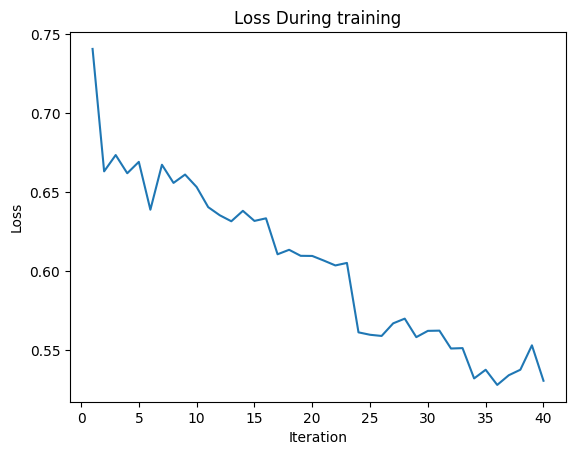

In [14]:
if is_local_simulator:
    lqm.plot_loss(losses_valid)
    plt.savefig(os.path.join(save_folder, "validation_loss.png"))

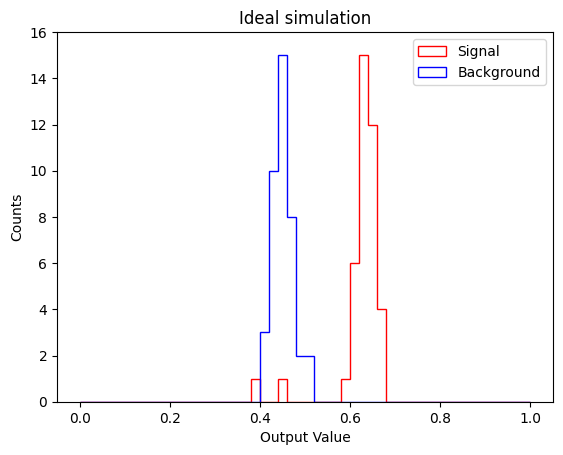

In [15]:
lqm.plot_class_hist(probs_test, test_labels)
plt.ylim([0, 16])
plt.title("Ideal simulation")
plt.savefig(os.path.join(save_folder, "classhist.png"))

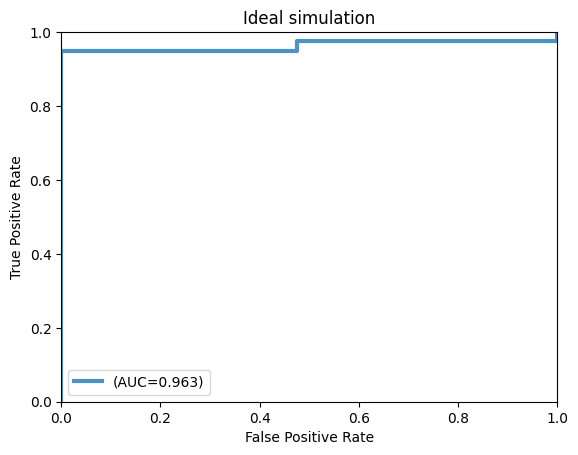

In [16]:
lqm.plot_roc(probs_test, test_labels)
plt.title("Ideal simulation")
plt.savefig(os.path.join(save_folder, "roc.png"))







| | predict 0 | predict 1|
|---|---|---|
|true 0|  38 | 2 |
|true 1|  2 | 38 |


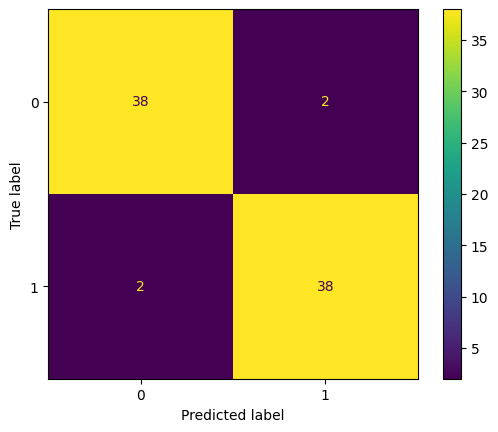

In [17]:
cm = confusion_matrix(test_labels, preds_test)
ConfusionMatrixDisplay(cm).plot()

print("\n\n\n\n\n")

# also print a table in the markdown format
print("| | predict 0 | predict 1|")
print("|---|---|---|")
print(f"|true 0|  {cm[0, 0]} | {cm[0, 1]} |")
print(f"|true 1|  {cm[1, 0]} | {cm[1, 1]} |")

In [18]:
print("\n\n\n\n\n")


print("| range | n signal | n background | percentage signal  | percentage background|")
print("|---|---|---|---|---|")

cuts = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


for cut in cuts:
    filter = (probs_test > cut)
    filtered_labels = test_labels[filter]

    n_total = len(filtered_labels)
    n_signal = np.sum(filtered_labels).astype(int)
    n_background = n_total-n_signal
    
    per_signal = n_signal/n_total * 100
    per_background = n_background/n_total * 100

    print(f"| >{cut:.1f} | {n_signal} | {n_background} | {per_signal:.1f}%  |  {per_background:.1f}% | ")









| range | n signal | n background | percentage signal  | percentage background|
|---|---|---|---|---|
| >0.4 | 39 | 40 | 49.4%  |  50.6% | 
| >0.5 | 38 | 2 | 95.0%  |  5.0% | 
| >0.6 | 37 | 0 | 100.0%  |  0.0% | 
| >0.7 | 0 | 0 | nan%  |  nan% | 
| >0.8 | 0 | 0 | nan%  |  nan% | 
| >0.9 | 0 | 0 | nan%  |  nan% | 


/var/folders/fj/c2fmbjm91p3dkw_8qls_6y900000gn/T/ipykernel_50272/3221164460.py:18: RuntimeWarning: invalid value encountered in long_scalars
  per_signal = n_signal/n_total * 100
/var/folders/fj/c2fmbjm91p3dkw_8qls_6y900000gn/T/ipykernel_50272/3221164460.py:19: RuntimeWarning: invalid value encountered in long_scalars
  per_background = n_background/n_total * 100
